# Компʼютерний практикум №12
Виконав студент групи ЗК-41мп Гломозда Костянтин

TRANSFER LEARNING (ЧАСТИНА I). АРХІТЕКТУРА RESNET18, RESNET20, CIFARNET

Load data

In [1]:
import torch
import torchvision.datasets
import random
import numpy as np
import time
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

CIFAR_train = torchvision.datasets.CIFAR10('./data', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./data', download=True, train=False)
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

X_train /= 255.
X_test /= 255.

Files already downloaded and verified
Files already downloaded and verified


Visualize

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

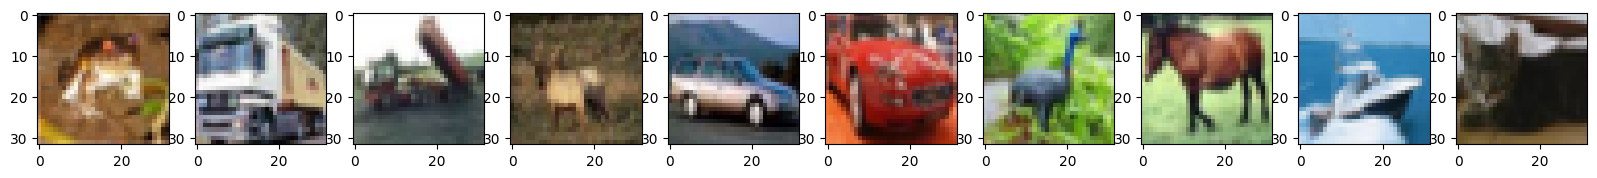

In [2]:
plt.figure(figsize=(20, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')
plt.show()

Prepare data

In [2]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

Train func

In [3]:
def train(net, X_train, y_train, X_test, y_test, batch_size=256,
          epoch_num=50, epoch_info_show=10,
          weight_decay=0, save_net_state=False, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=weight_decay)
    t = time.time()
    test_accuracy_history = []
    test_loss_history = []
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(1, epoch_num+1):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            preds = net.forward(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)
            accuracy = (test_preds.argmax(dim=1) ==
            y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
            if verbose:
                if epoch % epoch_info_show == 0:
                    if device.type == 'cuda':
                        print('Train Epoch: {} Time: {} Accuracy: {},\
                        GPU_Mem_alloc: {} GPU_Mem_cashed: {}'.format(epoch,
                        time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), accuracy,
                        torch.cuda.memory_allocated(), torch.cuda.memory_reserved()))
                    else:
                        print('Train Epoch: {} Time: {} Accuracy:\
                        {}'.format(epoch, time.strftime("%H:%M:%S", time.gmtime(time.time() - t)),
                        accuracy))
    net_state = net.state_dict()
    del net
    if save_net_state:
        return test_accuracy_history, test_loss_history, net_state
    else:
        return test_accuracy_history, test_loss_history
        
accuracies = {}
losses = {}

Visualize

In [4]:
sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(15, 6)})
def acc_loss_graph(accuracies, losses, net_list,
    save_file_name='plot.png', download=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for experiment_id in net_list:
        ax1.plot(accuracies[experiment_id], label=experiment_id)
        
    ax1.legend()
    ax1.set_title('Validation Accuracy')
    fig.tight_layout()
    for experiment_id in net_list:
        ax2.plot(losses[experiment_id], label=experiment_id)
        
    ax2.legend()
    ax2.set_title('Validation Loss')
    fig.tight_layout()
    if download:
        fig.savefig(save_file_name)

CIFARNet network

In [21]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)
        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1 = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2 = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3 = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)
        self.fc1 = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4 = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        self.fc2 = torch.nn.Linear(256, 64)
        self.act5 = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        self.fc3 = torch.nn.Linear(64, 10)
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        return x

Train CIFAR10

Train Epoch: 10 Time: 00:00:03 Accuracy: 0.7023999691009521,                        GPU_Mem_alloc: 808868352 GPU_Mem_cashed: 3154116608
Train Epoch: 20 Time: 00:00:07 Accuracy: 0.7134999632835388,                        GPU_Mem_alloc: 808868352 GPU_Mem_cashed: 3154116608
Train Epoch: 30 Time: 00:00:10 Accuracy: 0.708899974822998,                        GPU_Mem_alloc: 808868352 GPU_Mem_cashed: 3154116608
Train Epoch: 40 Time: 00:00:14 Accuracy: 0.7146999835968018,                        GPU_Mem_alloc: 808868352 GPU_Mem_cashed: 3154116608
Train Epoch: 50 Time: 00:00:18 Accuracy: 0.7080000042915344,                        GPU_Mem_alloc: 808868352 GPU_Mem_cashed: 3154116608


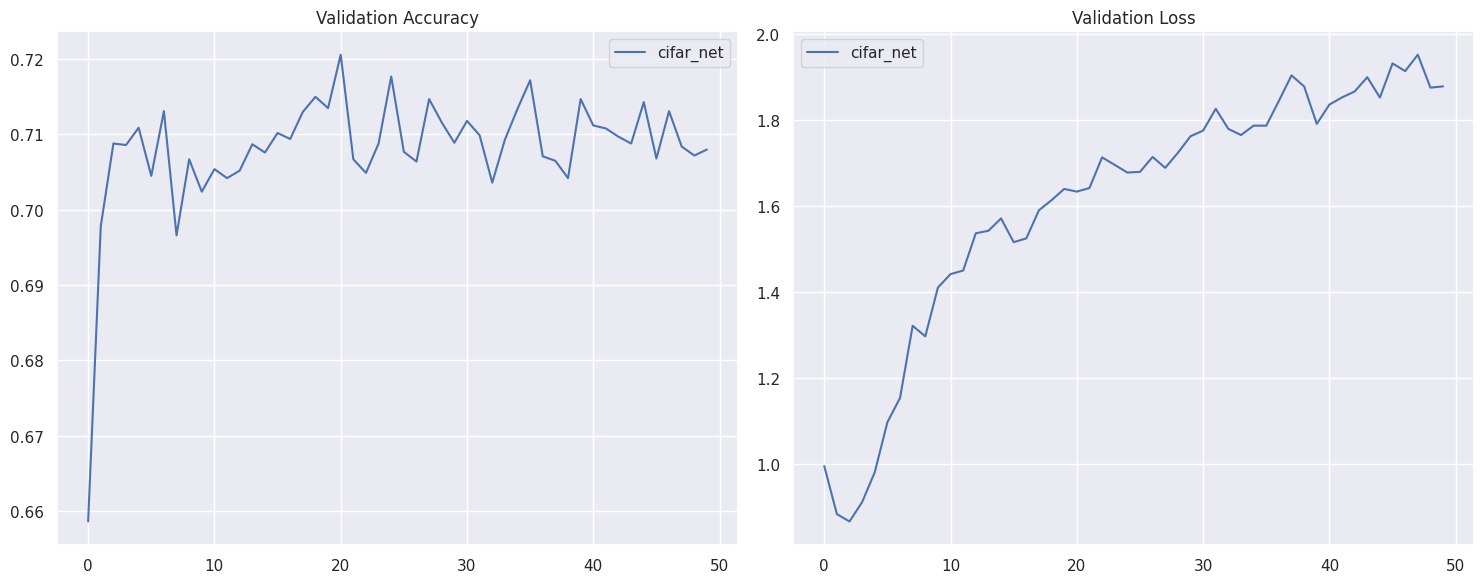

In [22]:
accuracies['cifar_net'], losses['cifar_net'] = train(CIFARNet(), X_train, y_train, X_test, y_test)
acc_loss_graph(accuracies, losses, ['cifar_net'])

ResNet18

Train Epoch: 10 Time: 00:00:10 Accuracy: 0.7206999659538269,                        GPU_Mem_alloc: 1021103104 GPU_Mem_cashed: 3154116608
Train Epoch: 20 Time: 00:00:20 Accuracy: 0.7204999923706055,                        GPU_Mem_alloc: 1021103104 GPU_Mem_cashed: 3154116608
Train Epoch: 30 Time: 00:00:30 Accuracy: 0.6917999982833862,                        GPU_Mem_alloc: 1021103104 GPU_Mem_cashed: 3154116608
Train Epoch: 40 Time: 00:00:40 Accuracy: 0.7275999784469604,                        GPU_Mem_alloc: 1021103104 GPU_Mem_cashed: 3154116608
Train Epoch: 50 Time: 00:00:51 Accuracy: 0.7446999549865723,                        GPU_Mem_alloc: 1021103104 GPU_Mem_cashed: 3154116608


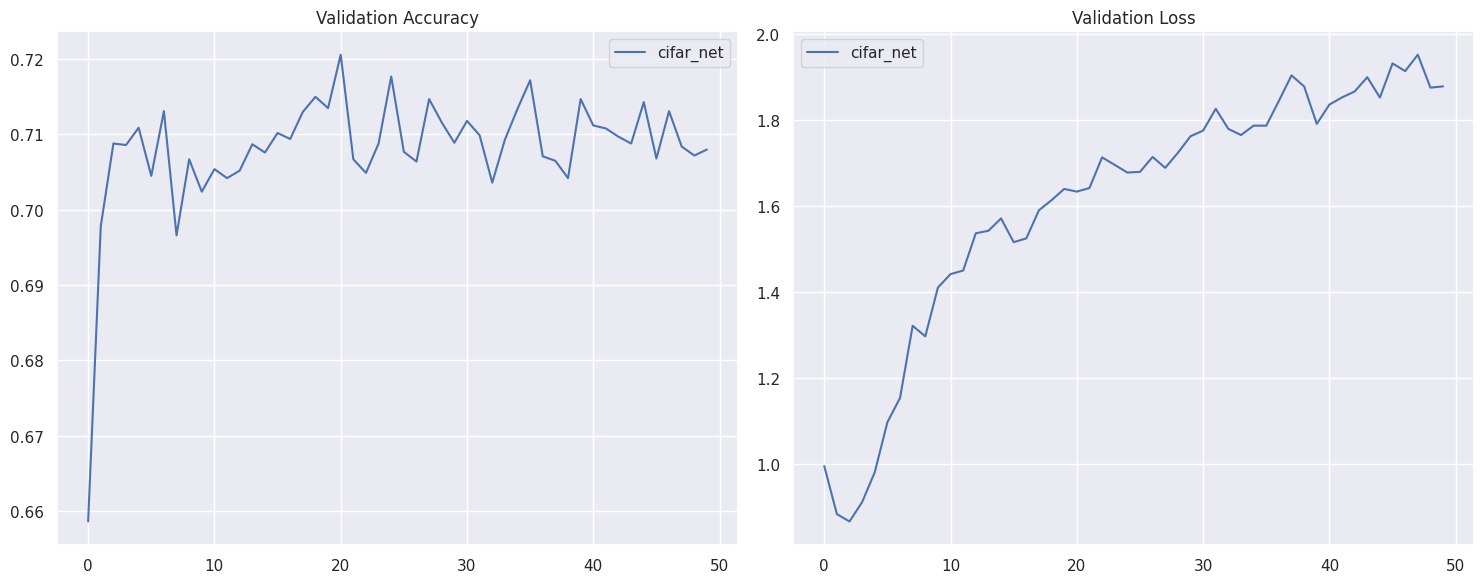

In [23]:
from torchvision.models import resnet18
import torch.optim as optim

accuracies['resnet18'], losses['resnet18'] = train(resnet18(), X_train, y_train, X_test, y_test)
acc_loss_graph(accuracies, losses, ['cifar_net'])

ResNet з нуля

In [24]:
class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)
    
    
class BasicBlock(torch.nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, option='A',
        use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(BasicBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.act = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=3,
        stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3,
        stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.d_out2 = torch.nn.Dropout2d(d_out_p)
        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                self.shortcut = LambdaLayer(lambda x: torch.nn.functional.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = torch.nn.Sequential(
                    torch.nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    torch.nn.BatchNorm2d(self.expansion * planes)
                )
    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
            out = self.bn1(out)
        if self.use_drop_out:
            out = self.d_out1(out)
        out = self.act(out)
        out = self.conv2(out)
        
        if self.use_batch_norm:
            out = self.bn2(out)
        if self.use_drop_out:
            out = self.d_out2(out)
            
        out += self.shortcut(x)
        out = self.act(out)
        return out
    
class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(ResNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.in_planes = 16
        self.act = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64, num_classes)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,
                          use_batch_norm=self.use_batch_norm,
                          use_drop_out=self.use_drop_out,
                          d_out_p=self.d_out_p))
            self.in_planes = planes * block.expansion
        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
            out = self.bn1(out)
        if self.use_drop_out:
            out = self.d_out1(out)
        out = self.act(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Modification

In [25]:
def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])
def resnet110_no_bn():
    return ResNet(BasicBlock, [18, 18, 18], use_batch_norm=False)
def resnet110_d_out15():
    return ResNet(BasicBlock, [18, 18, 18], use_drop_out=True, d_out_p=0.15)
def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])
def resnet20_d_out5():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True)
def resnet20_d_out3(**kwargs):
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.3)
def resnet20_d_out8():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.8)
def resnet20_d_out15():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.15)

In [26]:
print(*[key for key, value in accuracies.items()])

cifar_net resnet18


Train Epoch: 10 Time: 00:00:14 Accuracy: 0.7285999655723572,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3810525184
Train Epoch: 20 Time: 00:00:28 Accuracy: 0.7343999743461609,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3810525184


Train Epoch: 30 Time: 00:00:42 Accuracy: 0.7608999609947205,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3810525184
Train Epoch: 40 Time: 00:00:56 Accuracy: 0.7432999610900879,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3810525184
Train Epoch: 50 Time: 00:01:10 Accuracy: 0.7768999934196472,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3810525184


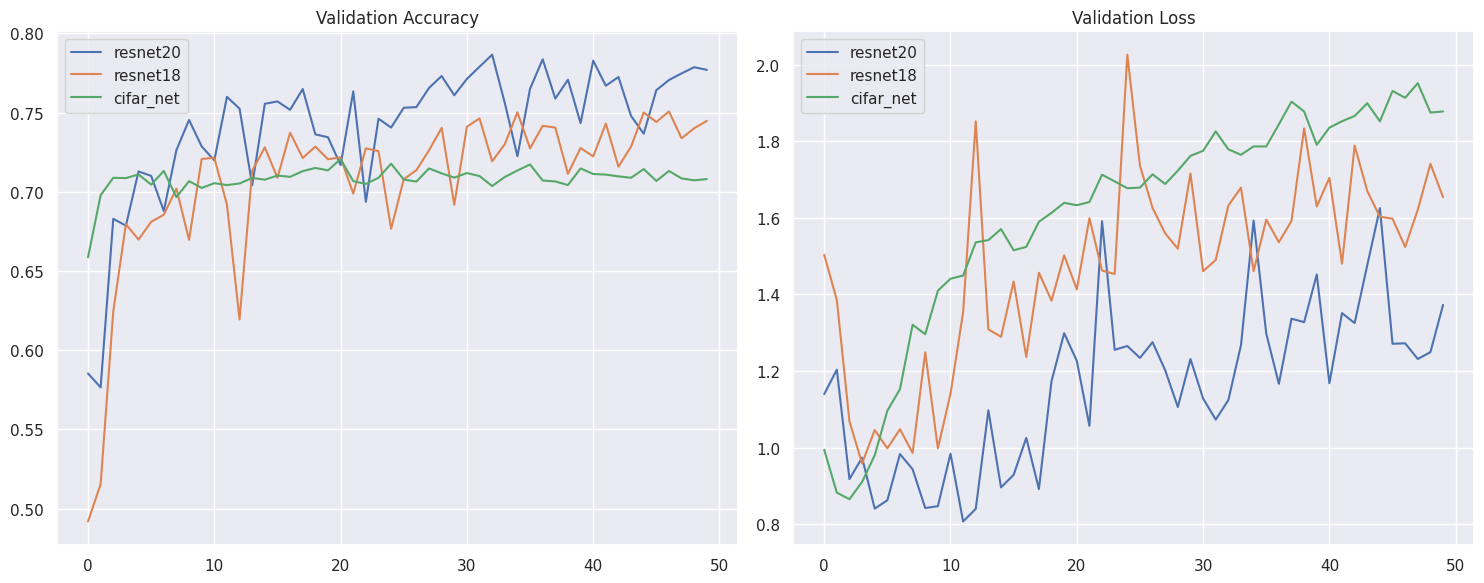

In [27]:
accuracies['resnet20'], losses['resnet20'] = train(resnet20(), X_train, y_train, X_test, y_test)
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet18', 'cifar_net'])

ResNet110 with batchNorm

Train Epoch: 10 Time: 00:02:13 Accuracy: 0.8364999890327454,                        GPU_Mem_alloc: 321470976 GPU_Mem_cashed: 3871342592
Train Epoch: 10 Time: 00:01:22 Accuracy: 0.6365999579429626,                        GPU_Mem_alloc: 321136128 GPU_Mem_cashed: 3871342592
Train Epoch: 10 Time: 00:00:28 Accuracy: 0.8033999800682068,                        GPU_Mem_alloc: 297739776 GPU_Mem_cashed: 3871342592
Train Epoch: 20 Time: 00:00:56 Accuracy: 0.8138999938964844,                        GPU_Mem_alloc: 297739776 GPU_Mem_cashed: 3871342592
Train Epoch: 30 Time: 00:01:24 Accuracy: 0.8048999905586243,                        GPU_Mem_alloc: 297739776 GPU_Mem_cashed: 3871342592
Train Epoch: 40 Time: 00:01:53 Accuracy: 0.8091999888420105,                        GPU_Mem_alloc: 297739776 GPU_Mem_cashed: 3871342592
Train Epoch: 50 Time: 00:02:22 Accuracy: 0.821399986743927,                        GPU_Mem_alloc: 297739776 GPU_Mem_cashed: 3871342592


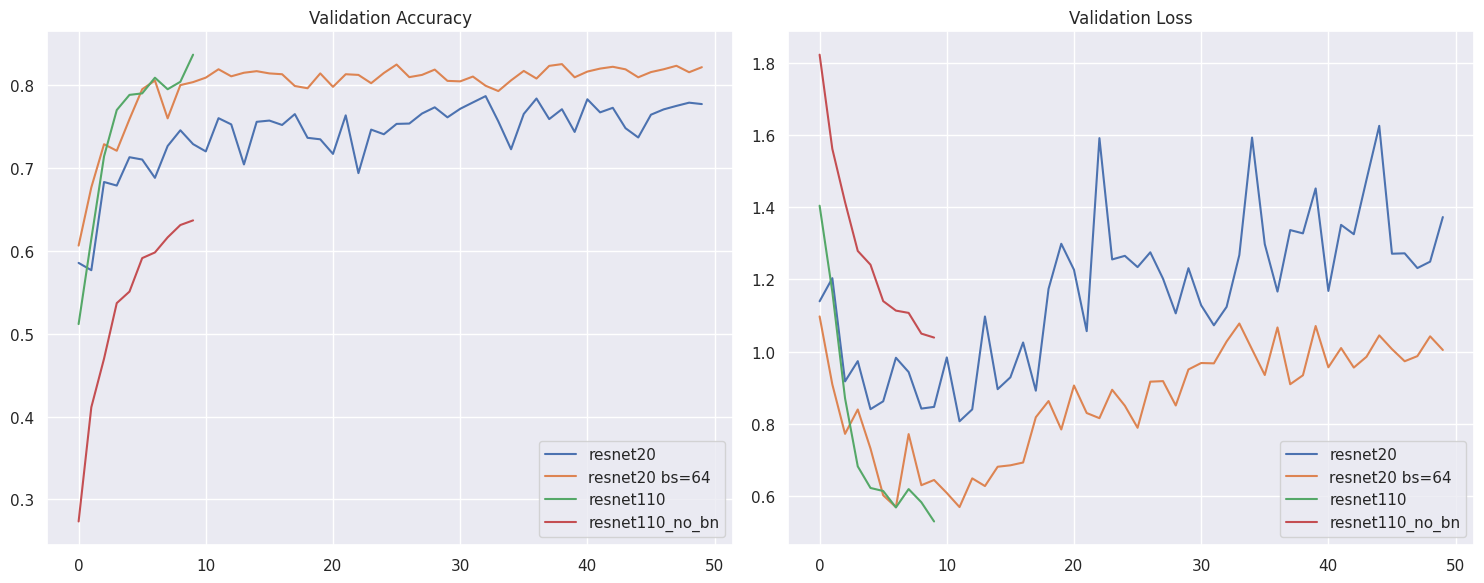

In [28]:
accuracies['resnet110'], losses['resnet110'] = train(resnet110(), X_train, y_train, X_test, y_test, batch_size=64, epoch_num=10)
accuracies['resnet110_no_bn'], losses['resnet110_no_bn'] = train(resnet110_no_bn(), X_train, y_train, X_test, y_test, batch_size=64, epoch_num=10)
accuracies['resnet20 bs=64'], losses['resnet20 bs=64'] = train(resnet20(), X_train, y_train, X_test, y_test, batch_size=64)
acc_loss_graph(accuracies, losses, ['resnet20','resnet20 bs=64', 'resnet110', 'resnet110_no_bn'])

DropOut ResNet20

Train Epoch: 10 Time: 00:00:14 Accuracy: 0.4440999925136566,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 20 Time: 00:00:29 Accuracy: 0.5012999773025513,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 30 Time: 00:00:44 Accuracy: 0.5753999948501587,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 40 Time: 00:00:59 Accuracy: 0.613599956035614,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 50 Time: 00:01:14 Accuracy: 0.6455999612808228,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 10 Time: 00:00:14 Accuracy: 0.6096000075340271,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 20 Time: 00:00:29 Accuracy: 0.7116999626159668,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 30 Time: 00:00:44 Accuracy: 0.768000

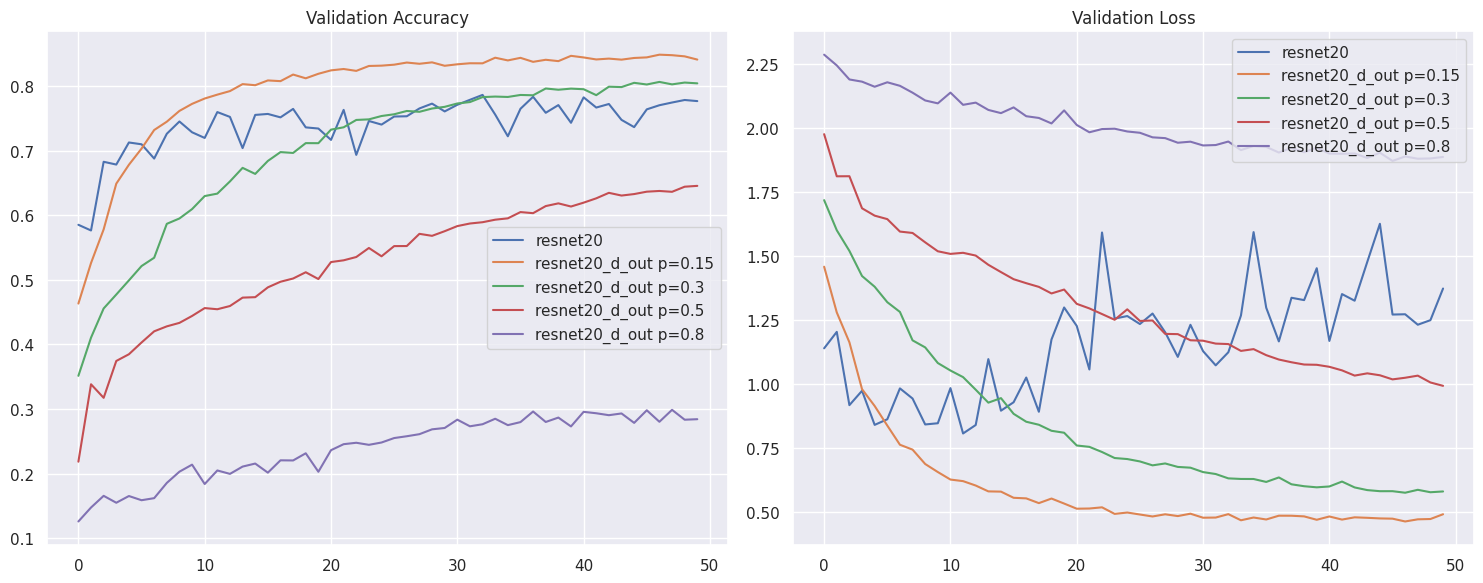

In [29]:
accuracies['resnet20_d_out p=0.5'], losses['resnet20_d_out p=0.5'] = train(resnet20_d_out5(), X_train, y_train, X_test, y_test)
accuracies['resnet20_d_out p=0.3'], losses['resnet20_d_out p=0.3'] = train(resnet20_d_out3(), X_train, y_train, X_test, y_test)
accuracies['resnet20_d_out p=0.8'], losses['resnet20_d_out p=0.8'] = train(resnet20_d_out8(), X_train, y_train, X_test, y_test)
accuracies['resnet20_d_out p=0.15'], losses['resnet20_d_out p=0.15'] = train(resnet20_d_out15(), X_train, y_train, X_test, y_test)
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet20_d_out p=0.15', 'resnet20_d_out p=0.3', 'resnet20_d_out p=0.5', 'resnet20_d_out p=0.8' ])

L2-reg ResNet20

Train Epoch: 10 Time: 00:00:14 Accuracy: 0.7525999546051025,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 20 Time: 00:00:28 Accuracy: 0.7490999698638916,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 30 Time: 00:00:42 Accuracy: 0.7791999578475952,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 40 Time: 00:00:56 Accuracy: 0.7767999768257141,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 50 Time: 00:01:10 Accuracy: 0.7904999852180481,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 10 Time: 00:00:14 Accuracy: 0.7457000017166138,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 20 Time: 00:00:28 Accuracy: 0.7037000060081482,                        GPU_Mem_alloc: 298529280 GPU_Mem_cashed: 3871342592
Train Epoch: 30 Time: 00:00:42 Accuracy: 0.78049

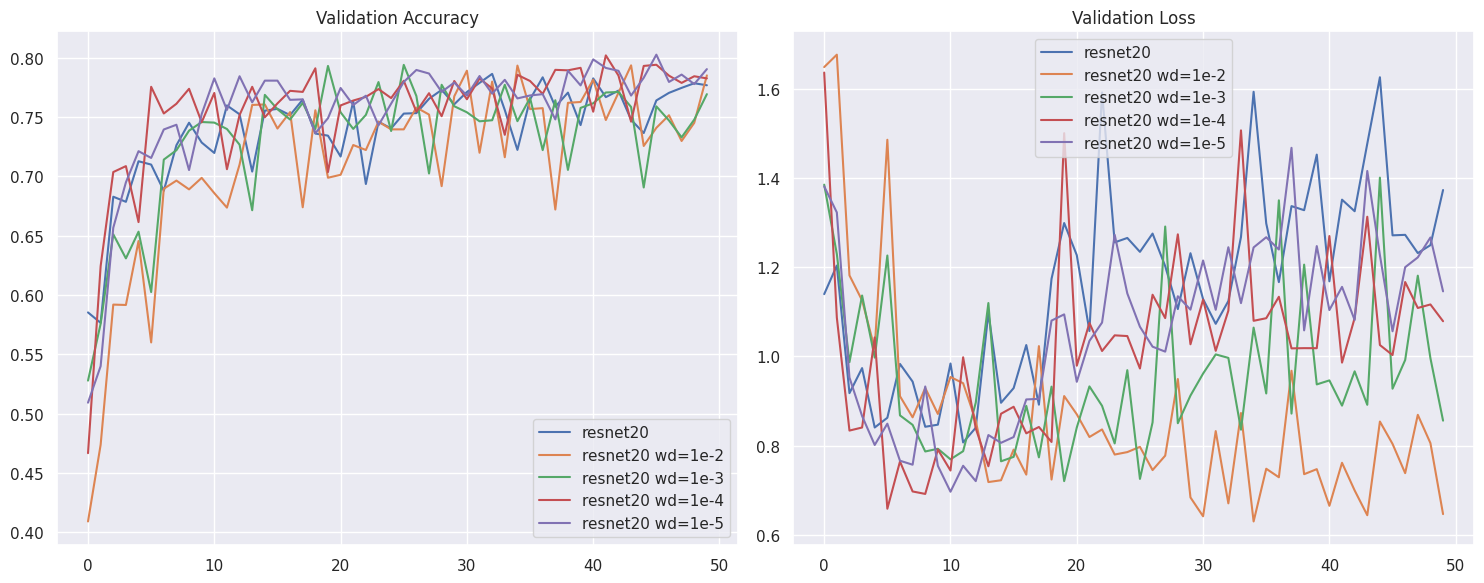

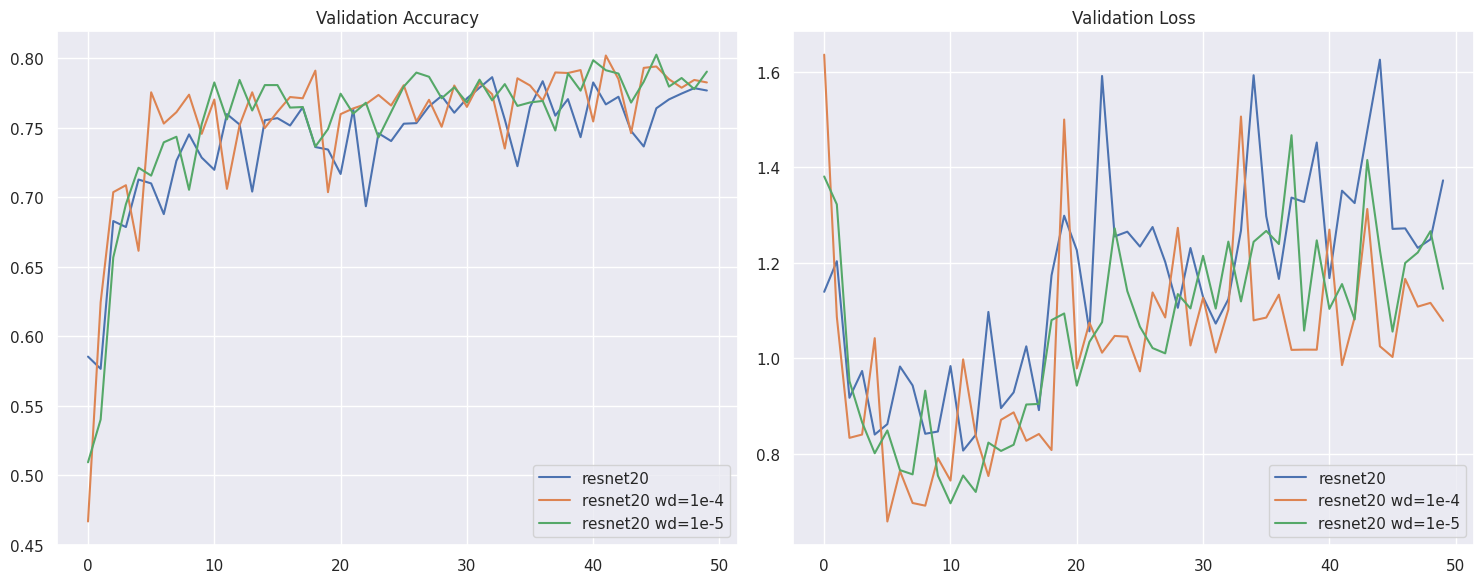

In [30]:
accuracies['resnet20 wd=1e-5'], losses['resnet20 wd=1e-5'] = train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-5)
accuracies['resnet20 wd=1e-4'], losses['resnet20 wd=1e-4'] = train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-4)
accuracies['resnet20 wd=1e-3'], losses['resnet20 wd=1e-3'] = train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-3)
accuracies['resnet20 wd=1e-2'], losses['resnet20 wd=1e-2'] = train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-2)
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet20 wd=1e-2', 'resnet20 wd=1e-3','resnet20 wd=1e-4', 'resnet20 wd=1e-5'])
acc_loss_graph(accuracies, losses, ['resnet20','resnet20 wd=1e-4', 'resnet20 wd=1e-5'])

L2-reg ResNet110

Train Epoch: 10 Time: 00:02:43 Accuracy: 0.8118999600410461,                        GPU_Mem_alloc: 321470976 GPU_Mem_cashed: 3871342592
Train Epoch: 10 Time: 00:00:34 Accuracy: 0.7994999885559082,                        GPU_Mem_alloc: 304899072 GPU_Mem_cashed: 3871342592
Train Epoch: 20 Time: 00:01:09 Accuracy: 0.8287000060081482,                        GPU_Mem_alloc: 304899072 GPU_Mem_cashed: 3871342592
Train Epoch: 30 Time: 00:01:45 Accuracy: 0.8385999798774719,                        GPU_Mem_alloc: 304899072 GPU_Mem_cashed: 3871342592
Train Epoch: 40 Time: 00:02:20 Accuracy: 0.8446999788284302,                        GPU_Mem_alloc: 304899072 GPU_Mem_cashed: 3871342592
Train Epoch: 50 Time: 00:02:55 Accuracy: 0.8467999696731567,                        GPU_Mem_alloc: 304899072 GPU_Mem_cashed: 3871342592


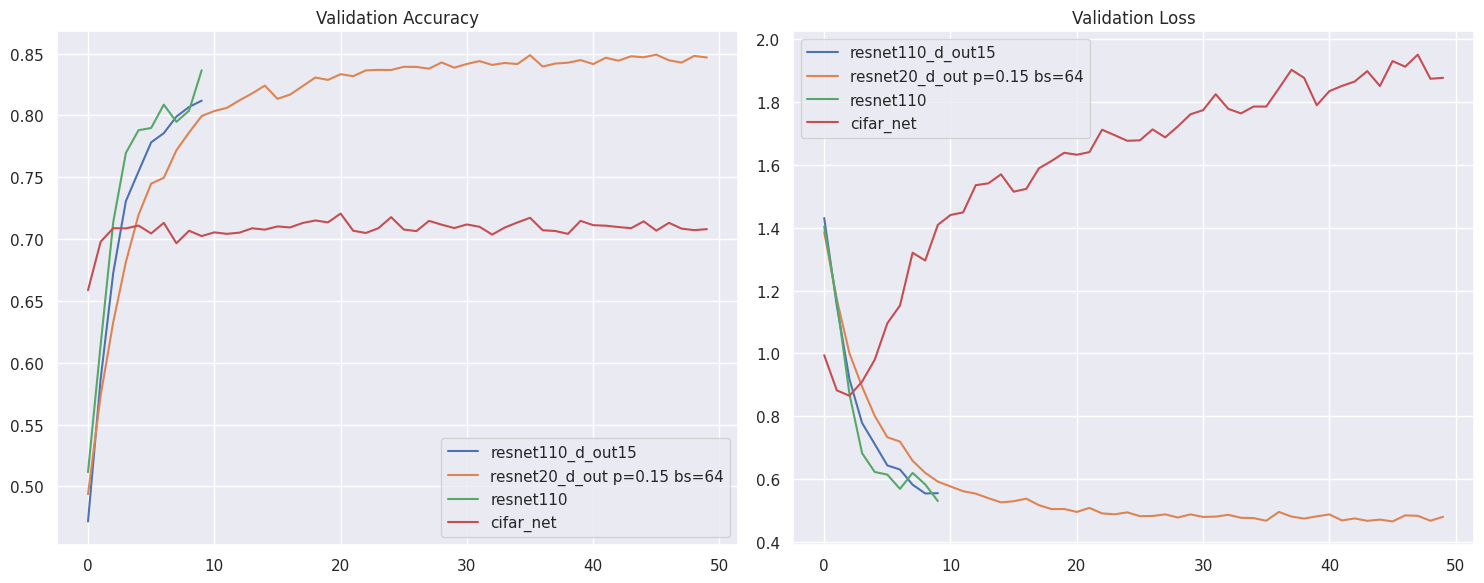

In [31]:
accuracies['resnet110_d_out15'], losses['resnet110_d_out15'], resnet110_d_out15_state = train(resnet110_d_out15(), X_train, y_train, X_test, y_test, batch_size=64, save_net_state=True, epoch_num=10)
accuracies['resnet20_d_out p=0.15 bs=64'], losses['resnet20_d_out p=0.15 bs=64'], resnet20_d_out15_state = train(resnet20_d_out15(), X_train, y_train, X_test, y_test, batch_size=64, save_net_state=True)
acc_loss_graph(accuracies, losses, ['resnet110_d_out15','resnet20_d_out p=0.15 bs=64', 'resnet110', 'cifar_net'])

Find the best model

In [32]:
print(*[key for key, _ in accuracies.items()])

cifar_net resnet18 resnet20 resnet110 resnet110_no_bn resnet20 bs=64 resnet20_d_out p=0.5 resnet20_d_out p=0.3 resnet20_d_out p=0.8 resnet20_d_out p=0.15 resnet20 wd=1e-5 resnet20 wd=1e-4 resnet20 wd=1e-3 resnet20 wd=1e-2 resnet110_d_out15 resnet20_d_out p=0.15 bs=64


In [34]:
for key, value in sorted(accuracies.items(), key=lambda x: -x[1][-1]):
    print(f"Model {key}, accuracy: {value[-1]}")

Model resnet20_d_out p=0.15 bs=64, accuracy: 0.8467999696731567
Model resnet20_d_out p=0.15, accuracy: 0.8411999940872192
Model resnet110, accuracy: 0.8364999890327454
Model resnet20 bs=64, accuracy: 0.821399986743927
Model resnet110_d_out15, accuracy: 0.8118999600410461
Model resnet20_d_out p=0.3, accuracy: 0.8043999671936035
Model resnet20 wd=1e-5, accuracy: 0.7904999852180481
Model resnet20 wd=1e-2, accuracy: 0.7851999998092651
Model resnet20 wd=1e-4, accuracy: 0.7827000021934509
Model resnet20, accuracy: 0.7768999934196472
Model resnet20 wd=1e-3, accuracy: 0.7694000005722046
Model resnet18, accuracy: 0.7446999549865723
Model cifar_net, accuracy: 0.7080000042915344
Model resnet20_d_out p=0.5, accuracy: 0.6455999612808228
Model resnet110_no_bn, accuracy: 0.6365999579429626
Model resnet20_d_out p=0.8, accuracy: 0.284199982881546


Проаналізуйте результат та зробіть висновки щодо впливу параметру р та шару Dropout взагалі.

Висновок - при збільшення параметра p зменшується точність, оскільки вимикається більше нейронів і модель не здатна достатньо навчитися. При надто малому значенні точність вища, але може бути ризик перенавчання

Custom ResNet20 with bottleneck (Optimized for low vram)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        reduced_planes = planes // 4  # Reduce the number of planes to reduce memory usage
        self.conv1 = nn.Conv2d(in_planes, reduced_planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(reduced_planes)
        self.conv2 = nn.Conv2d(reduced_planes, reduced_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(reduced_planes)
        self.conv3 = nn.Conv2d(reduced_planes, planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to reduce memory usage
        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)  # Reduced feature map size with adaptive pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet20():
    return ResNet(Bottleneck, [3, 3, 3])

Train Epoch: 10 Time: 00:00:33 Accuracy: 0.7622999548912048,                        GPU_Mem_alloc: 147379200 GPU_Mem_cashed: 14910750720
Train Epoch: 20 Time: 00:01:07 Accuracy: 0.7745999693870544,                        GPU_Mem_alloc: 147379200 GPU_Mem_cashed: 14910750720
Train Epoch: 30 Time: 00:01:40 Accuracy: 0.7608999609947205,                        GPU_Mem_alloc: 147379200 GPU_Mem_cashed: 14910750720


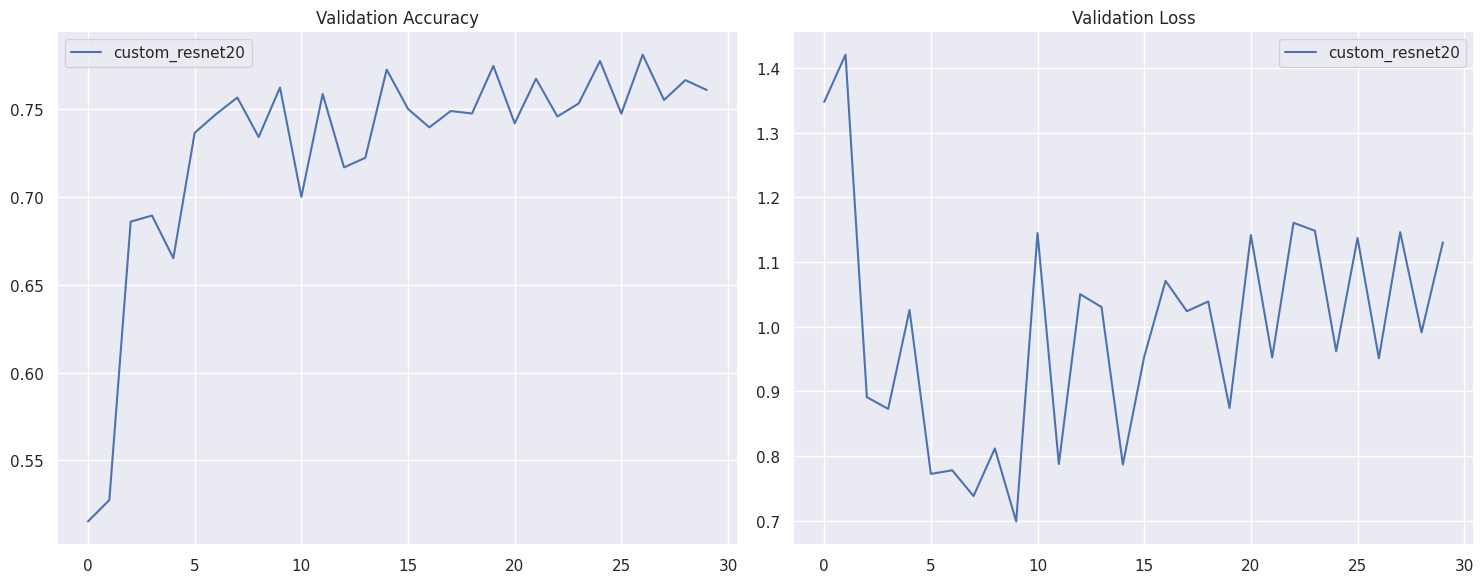

In [6]:
net = ResNet20()
accuracies['custom_resnet20'], losses['custom_resnet20'] = train(net, X_train, y_train, X_test, y_test, batch_size=256, epoch_num=30, epoch_info_show=10, weight_decay=1e-4)
acc_loss_graph(accuracies, losses, ['custom_resnet20'])

Custom ResNet100 without BatchNorm

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1, use_batchnorm=True):
        super(BasicBlock, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        if self.use_batchnorm:
            self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        if self.use_batchnorm:
            self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes) if self.use_batchnorm else nn.Identity()
            )

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        if self.use_batchnorm:
            out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, use_batchnorm=True):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.use_batchnorm = use_batchnorm
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        if self.use_batchnorm:
            self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.use_batchnorm))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet110(use_batchnorm=True):
    return ResNet(BasicBlock, [18, 18, 18], use_batchnorm=use_batchnorm)

Train Epoch: 10 Time: 00:01:17 Accuracy: 0.7217999696731567,                        GPU_Mem_alloc: 173021696 GPU_Mem_cashed: 14940110848
Train Epoch: 10 Time: 00:00:52 Accuracy: 0.09999999403953552,                        GPU_Mem_alloc: 172396544 GPU_Mem_cashed: 14940110848


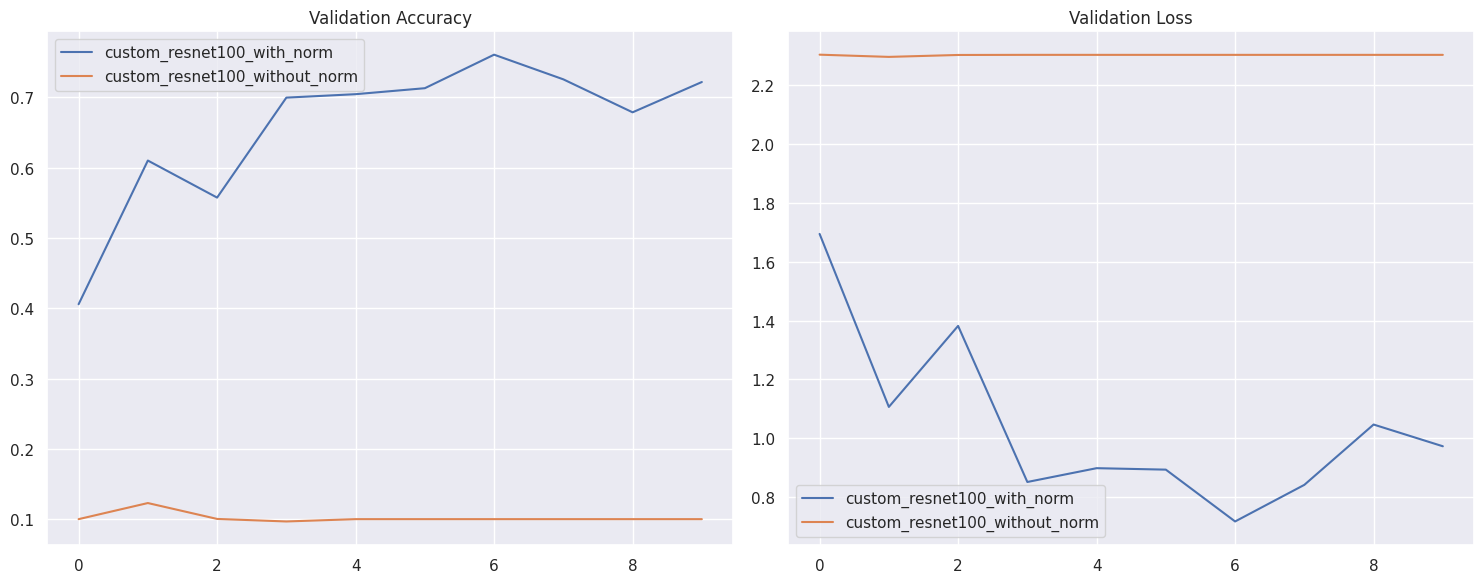

In [8]:
accuracies['custom_resnet100_with_norm'], losses['custom_resnet100_with_norm'] = train(ResNet110(), X_train, y_train, X_test, y_test, batch_size=256, epoch_num=10, epoch_info_show=10, weight_decay=1e-4)
accuracies['custom_resnet100_without_norm'], losses['custom_resnet100_without_norm'] = train(ResNet110(use_batchnorm=False), X_train, y_train, X_test, y_test, batch_size=256, epoch_num=10, epoch_info_show=10, weight_decay=1e-4)
acc_loss_graph(accuracies, losses, ['custom_resnet100_with_norm', 'custom_resnet100_without_norm'])

Перевірте твердження, що ResNet110 не піддаються навчанню (або навчається в 10% випадків)

Твердження вірне

Проаналізуйте як впиває BatchNorm на навчання. Як вплинуло зменшення розміру Батч? Що буде при наступному зменшенні розміру Батч? Чому?

Без BatchNorm мережі можуть демонструвати нестабільне навчання, і в багатьох випадках вони не досягають хороших результатів.

Зменшення розміру батчу збільшує швидкість навчання, але градієнти можуть стати більш розсіяними

Add L2 regularization

Train Epoch: 10 Time: 00:00:10 Accuracy: 0.6947000026702881,                        GPU_Mem_alloc: 374794752 GPU_Mem_cashed: 14942208000
Train Epoch: 20 Time: 00:00:20 Accuracy: 0.7210999727249146,                        GPU_Mem_alloc: 374794752 GPU_Mem_cashed: 14942208000
Train Epoch: 30 Time: 00:00:30 Accuracy: 0.7400999665260315,                        GPU_Mem_alloc: 374794752 GPU_Mem_cashed: 14942208000
Train Epoch: 10 Time: 00:00:10 Accuracy: 0.7188999652862549,                        GPU_Mem_alloc: 471874048 GPU_Mem_cashed: 14942208000
Train Epoch: 20 Time: 00:00:20 Accuracy: 0.7170000076293945,                        GPU_Mem_alloc: 471874048 GPU_Mem_cashed: 14942208000
Train Epoch: 30 Time: 00:00:30 Accuracy: 0.7222999930381775,                        GPU_Mem_alloc: 471874048 GPU_Mem_cashed: 14942208000


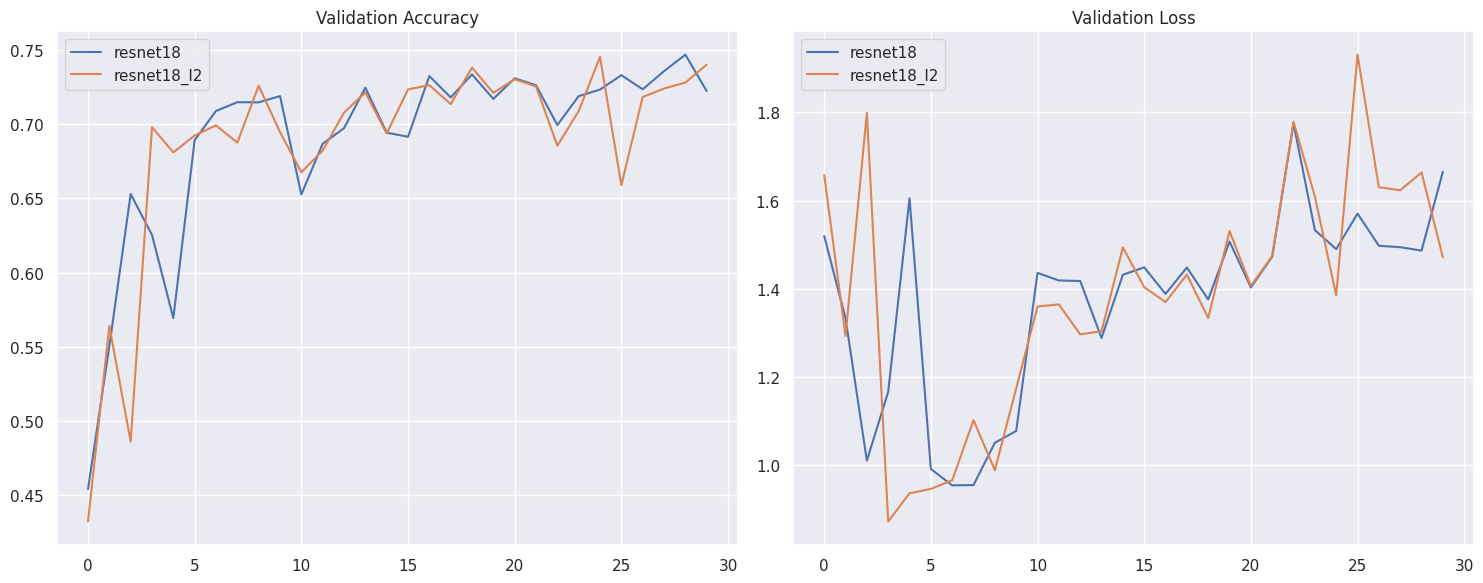

In [10]:
from torchvision.models import resnet18
import torch.optim as optim

model_l2 = resnet18()
optimizer = optim.Adam(model_l2.parameters(), lr=1e-3, weight_decay=1e-4)
accuracies['resnet18_l2'], losses['resnet18_l2'] = train(model_l2, X_train, y_train, X_test, y_test, epoch_num=30, epoch_info_show=10)
accuracies['resnet18'], losses['resnet18'] = train(resnet18(), X_train, y_train, X_test, y_test, epoch_num=30, epoch_info_show=10)
acc_loss_graph(accuracies, losses, ['resnet18', 'resnet18_l2'])

L2 регуляризація трохи збільшує точність моделі

Після створення моделей вручну, найкраща серед них вийшла ResNet20 з точністю 0.76

Але серед усіх моделей найвища точність у наступної:
Model resnet20_d_out p=0.15 bs=64, accuracy: 0.8467999696731567